# CSE 152 Homework 4  Video Understanding

In this homework, you will use the tools learned in class to solve object tracking and object discovery problems.

The due for this homework is scheduled one day after the final exam, which is ``Dec. 10th, 11:59 pm``

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter, convolve
import scipy
import warnings
from skimage.io import *
warnings.filterwarnings('ignore')
import cv2
from skimage import filters
import sys

## Question 1: Iterative KLT tracker (70 pts)

In this question, you will track a specific object in a given video (test.avi) by implementing an iterative KLT tracker. The KLT tracker works on two frames at a time, and estimates
the deformation between two image frames under the assumption that the
intensity of the objects has not changed significantly between the two frames.
In this homework, we assume the motion is translation only (the matrix
$P$ we learned from class is a translation matrix here). 

Starting with a
rectangle $R_t$ on frame $I_t$, the KLT tracker aims to move it by an offset $(u, v)$ to
obtain another rectangle $R_{t+1}$ on frame I_{t+1}, so that the pixel squared difference
in the two rectangles is minimized:
$$min_{u, v} J(u, v) = \Sigma_{x, y \in R_t}(I(x+u, y+v)-I(x, y))^2$$

## Question 1.1: Preliminary [10 pts]
Starting with an initial guess of $(u, v)$ (usually $(0,0)$), we can compute the
optimal $(u^∗
, v^∗
)$ iteratively. In each iteration, the objective function is locally
linearized by first-order Taylor expansion and optimized by solving a linear
system that has the form $A\delta_p = b$, where $\delta_p = (\delta_u, \delta_v)^\top$ is the template offset.
Please answer the following questions:
1. What is $A^\top A$? Using image gradient to derive it.
2. What conditions must $A^\top A$ meet so that the template offset can be calculated reliably? Explain why.

Your answer here:
<br/>
<br/>
<br/>

## Question 1.2 Iterative KLT Tracker Implementation (50 pts)

Complete the ``Iter_KLT`` method below, which computes the optimal local
motion from frame $I_t$ to frame $I_{t+1}$ that minimizes the objective in Question 1. 

1. Note that moving the template rectangle by $u$ and $v$ will lead to fractional coordinates of the pixels. However, you need to extract information within the rectangle every time step, such as the image intensity, image gradient. To deal with this issue, you can convert the coordinates to integers, or perform some interpolations for floating numbers.

2. You will also need to iterate the estimation until the change in $(u, v)$ is below a threshold, or reach a maximal iteration number. We set the threshold to be 0.005, and max iterations to be 1500. 

3. You can adjust every parameter you want to make the tracking more accurate.

The rectangle in the first frame is $[x_1, y_1, x_2, y_2] = [318, 208, 418, 268]$. In other words, the rectangle starts from (318, 208) (row 208 and column 318 in the
image) and ends at (418, 268). You need to understand the image coordinations correctly. 

If you complete this script correctly, it will play a video with a rectangle
tracking the car. You can refer ``fig1.png``, ``fig2.png``, ``fig3.png`` for reference.

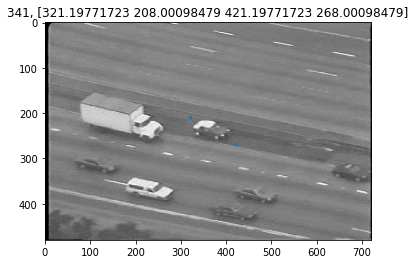

3.197717227452776 0.0009847894491217337


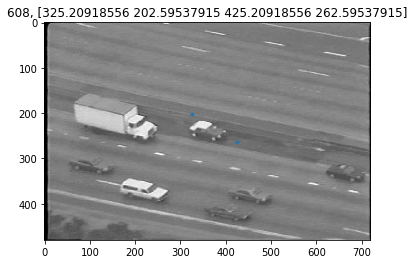

4.011468334998916 -5.405605642977283


In [ ]:
%matplotlib inline

def inbound(pt, rect):
    return (pt[1] >= rect[0] and pt[1] <= rect[2] and pt[0] >= rect[1] and pt[0] <= rect[3])

def Iter_KLT(I_t, I_t_1, rect, max_iter=1000, threshold=0.005):
    '''
    Input: 
        I_t: image frame at time t
        I_t_1: image frame at time t+1
        rect: tracking rectangle at time t
        max_iter: maximum iteration steps for iterative KLT tracker
        threshold: if delta_p's norm is smaller than the threshold, then the iterations will stop
    
    Return: 
        rect_new: tracking rectangle at time t+1
        You need to compute "delta_p" as the translation for the rectangle from t to t+1
    '''
    u = 0
    v = 0
    img_h, img_w = I_t_1.shape[0], I_t_1.shape[1]
    delta_p_length = 1000
    rect_new = rect.copy()

    # Extract image gradient at time t+1
    Ix = cv2.Sobel(I_t_1, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(I_t_1, cv2.CV_64F, 0, 1, ksize=5)

    iters = max_iter
    delta_p = [0, 0]
    iters = 0
    
    # Loop until "delta_p" is sufficiently small, or iteration number reaches max_iter
    while delta_p_length > threshold and iters < max_iter:
        if rect_new[0] < 0 or rect_new[1] < 0 or rect_new[2] >= img_w or rect_new[3] >= img_h:
            print('Tracking rectangle out of boundary!', rect_new)
            break
            
        ### You should calculate delta_p in the following codes
        
        # get harris corners within bounding box in I_t, points are (y, x)
        win_size = 3
        
        I_t = np.float32(I_t)
        I_t_1 = np.float32(I_t_1)
        It_pts = cv2.cornerHarris(I_t, 5, 5, .04)
        
        yx = np.where(It_pts > 0.00007)
        yx = np.hstack((yx[0].reshape(-1, 1), yx[1].reshape(-1, 1)))
        yx = np.array([i for i in yx if inbound(i, rect_new)])
        yx = np.hstack((yx, np.ones((len(yx), 1)))).astype(int)
        
        I_t_feats = np.array([I_t[y, x] for y, x, _ in yx])

        if len(yx) == 0:
            r = rect_new.reshape(2, 2)
            plt.imshow(I_t, 'gray')
            plt.title(f"{iters}, {rect_new}")
            plt.scatter(r[:, 0], r[:, 1], s=7)
            plt.show()
            assert len(yx) != 0
        
        # create warping matrix (translation)
        W = np.array([[1, 0, -v],
                      [0, 1, u]])
        
        # translate I_t feature coordinates by u, v
        yx_t = np.dot(yx, W.T).astype(int)
        
        # retrieve features from image
        I_t_1_feats = np.array([I_t_1[y, x] for y, x in yx_t])
        
        # retrieve gradients from within bounding box
        Ix_t = np.array([Ix[y, x] for y, x in yx_t]).flatten()
        Iy_t = np.array([Iy[y, x] for y, x in yx_t]).flatten()
        
        G = np.array([Ix_t, Iy_t])
        H = np.dot(G, G.T) 
        H_inv = np.linalg.inv(H)
        err = I_t_1_feats - I_t_feats
        
        delta_p = np.dot(H_inv, np.dot(G, err.flatten()))
        ### YOUR CODE ENDS
        
        u = u + delta_p[0]
        v = v + delta_p[1]
        delta_p_length = np.linalg.norm(delta_p)
        rect_new = np.array([rect[0]+u, rect[1]+v, rect[2]+u, rect[3]+v])
        iters += 1
        
    r = rect_new.reshape(2, 2)
    plt.imshow(I_t, 'gray')
    plt.title(f"{iters}, {rect_new}")
    plt.scatter(r[:, 0], r[:, 1], s=7)
    plt.show()
    print(u, v)
    
    return rect_new

cap = cv2.VideoCapture("test.avi")

# Initialized tracking rectangle of the car
rect = np.array([318, 208, 418, 268])

ret, old_frame = cap.read()
old_frame_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)/255.

# A mask to draw the tracking rectangle for initialization
mask = np.zeros_like(old_frame)
mask = cv2.rectangle(mask, (rect[0], rect[1]), (rect[2], rect[3]), color=(0, 0, 255))
img = cv2.add(old_frame, mask)
cv2.imshow('frame',img)
cv2.waitKey(30) & 0xff

while(1):
    # read video and turn it to grayscale using opencv
    ret,frame = cap.read()
    if ret is True:
        cur_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255.
    else:
        break
    
    rect_new = Iter_KLT(old_frame_gray, cur_frame_gray, rect)
    # update old frame and tracking rectangle
    old_frame_gray = cur_frame_gray.copy()
    rect = rect_new.copy()

cv2.destroyWindow('frame')
cv2.waitKey(1)
cap.release()

In [ ]:
        HARRIS_THRESH = 0.04
        I_t = I_t * 255
        I_t = cv2.convertScaleAbs(I_t)
        T = cv2.cornerHarris(I_t, 5, 5, HARRIS_THRESH)
        
        I_t_1 = I_t_1 * 255
        I_t_1 = cv2.convertScaleAbs(I_t_1)
        
        # translate image
        xx, yy = np.meshgrid(np.arange(img_w), np.arange(img_h))
        xx = xx[:, :, None]
        yy = yy[:, :, None]
        o = np.ones_like(yy)
        
        xy = np.concatenate((xx, yy, o), axis=-1).reshape((-1, 3))

        W = np.array([[1, 0, u], 
                      [0, 1, v]]).T
    
        xy_t = np.dot(xy, W)
        T_t = np.zeros_like(T)
        
        for idx, idx_t in zip(xy[:, :2], xy_t):
            x, y = idx.astype(int)
            x_t, y_t = idx_t.astype(int)
            if x_t < 0 or y_t < 0 or y_t >= img_h or x_t >= img_w:
                continue
            T_t[y, x] = T[y_t, x_t]
        
        # inds for the prev image
        inds_p = np.where(T >= HARRIS_THRESH)
        inds_p = np.concatenate((inds_p[0].reshape(-1, 1), inds_p[1].reshape(-1, 1)), axis=-1)
#         inds_p = 
        
        # inds for the curr image
        inds_t = np.where(T_t >= HARRIS_THRESH)
        inds_t = np.concatenate((inds_t[0].reshape(-1, 1), inds_t[1].reshape(-1, 1)), axis=-1)
        
        # get intensity values to compare
        prev = np.array([I_t[ind[0], ind[1]] for ind in inds_p])
        curr = np.array([I_t_1[ind[0], ind[1]] for ind in inds_t])
        Ix_h = np.array([Ix[ind[0], ind[1]] for ind in inds_t])
        Iy_h = np.array([Iy[ind[0], ind[1]] for ind in inds_t])
        
        # error between previous and current
        err = curr - prev 
        H = np.array([
            [np.square(Ix_h).sum(), (Ix_h * Iy_h).sum()],
            [(Ix_h * Iy_h).sum(), np.square(Ix_h).sum()],
        ])
        H_1 = np.linalg.inv(H)
#         delta_p = np.dot(H_1, np.dot(np.array([Ix_h, Iy_h]), err))
        delta_p = np.dot(H_1, np.dot(np.array([Ix_h, Iy_h]), err.reshape(-1, 1))) / 1000
        
        ### YET ANOTHER
#         xx, yy = np.meshgrid(np.arange(rect_new[0], rect_new[2] + 1), np.arange(rect_new[1], rect_new[3] + 1))
#         xx = xx[:, :, None]
#         yy = yy[:, :, None]
#         o = np.ones_like(xx)
#         xy = np.concatenate((xx, yy, o), axis=-1).reshape(-1, 3).astype(int)
#         I_t_feats = np.array([I_t[j, i] for i, j, _ in xy])
        
#         print(I_t_feats)
#         sys.exit(0)
        

SystemExit: 1

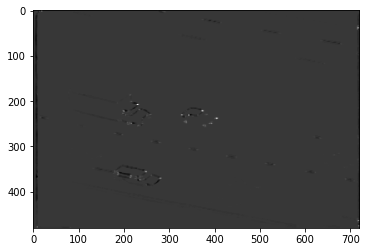

In [120]:
cap = cv2.VideoCapture("test.avi")

# Initialized tracking rectangle of the car
rect = np.array([318, 208, 418, 268])

ret, old_frame = cap.read()
old_frame_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)/255.

# A mask to draw the tracking rectangle for initialization
mask = np.zeros_like(old_frame)
mask = cv2.rectangle(mask, (rect[0], rect[1]), (rect[2], rect[3]), color=(0, 0, 255))
img = cv2.add(old_frame, mask)
cv2.imshow('frame',img)
cv2.waitKey(30) & 0xff

while(1):
    # read video and turn it to grayscale using opencv
    ret,frame = cap.read()
    if ret is True:
        cur_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255.
    else:
        break
    
    rect_new = Iter_KLT(old_frame_gray, cur_frame_gray, rect)
    
    # Clear the mask to draw the tracking rectangle every step
    mask = np.zeros_like(frame)
    mask = cv2.rectangle(mask, (rect_new[0], rect_new[1]), (rect_new[2], rect_new[3]), color=(0, 0, 255), thickness=2)
    img = cv2.add(frame, mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
    # update old frame and tracking rectangle
    old_frame_gray = cur_frame_gray.copy()
    rect = rect_new.copy()

cv2.destroyWindow('frame')
cv2.waitKey(1)
cap.release()

## Question 1.3 Visualization (10 pts)

Plot your tracking result (image + rectangle) at frame 5,
frame 20, frame 50 and frame 90 below.

In [ ]:
### YOUR CODE HERE
pass
### YOUR CODE ENDS

## Question 2 Moving Object Discovery (50 pts, contains 20 pts extra credit)

In this problem, you are provided with a video game, which contains some moving objects as well as fixed objects, which is ``video_game.mp4``

Design an algorithm that will find the moving objects in the video (30 pts).

We do not have any specific requirements. Please do you best to achieve this open-ended task. However, following are some hints:

1. Use optical flow method to compute the flow of the moving objects. You can use APIs provided in OpenCV, like https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html). To use the sample code in this link, you need to figure out a method to select the points of interest. Simply using the corner extraction will introduce some corners remain fixed for the video.

2. You can represent a moving object in your own way. For example, you can use rectangles like in problem 1 / a binary mask / some keypoints / trajetories. You should select at least 5 representative frames, and plot the moving object in the frame. Binary masks and rectangles are usually more challenging, we will give more credits on that.

3. Give detailed analysis based on your results. (Failure cases? Efficiency?) Propose a potential improvement.

Requirements for extra credits (+20 pts):

1. Propose novel solutions to handle the corner cases. 
2. Provide visualization of your improvements and give analysis on that.

We understand that the approach description is vague. But we expect to witness your engineering skills to solve this problem :). Please treat it as a small "final project".